In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
np.set_printoptions(threshold=np.inf)

In [21]:
def update_wm(image, h_new, w_new):
    """
    Make watermark as large as container
    """
    h, w = image.shape
    while True:
        image = np.concatenate((image, image), axis=1)
        if image.shape[1]>w_new:
            break
    while True:
        image = np.concatenate((image, image), axis=0)
        if image.shape[0]>h_new:
            break
    image = image[:h_new, :w_new]
    return image

In [22]:
def insert_wm(container, wm, bit):
    """
    Inserting watermark into image
    """
    h_c, w_c, _ = container.shape
    h_wm,w_wm = wm.shape
    # if container bigger
    if h_wm < h_c or w_wm < w_c:
        wm = update_wm(wm, h_c, w_c)
    # if container smaller  
    if h_wm > h_c or w_wm > w_c:
        wm = wm[:h_c, :w_c]

    # making image 0 and 1
    wm = wm & 1
    # making three streams
    r, g, b = cv2.split(container)

    # Bit demonstration of int8 values
    b_unpacked = np.unpackbits(b[:,:,np.newaxis], axis=2)
    # Changing bits
    b_unpacked[:,:, -bit] = wm[:, :]
    # Change bit demonstration to int8
    b_packed = np.packbits(b_unpacked, axis=2)
    b_new = b_packed.reshape(b_packed.shape[0],b_packed.shape[1])
    # Making new image
    modified_image = cv2.merge((r, g, b_new))
    return modified_image

In [23]:
def extrect_wm(container, bit):
    """
    Extrecting watermark from image
    """
    _, _, b_mod = cv2.split(container)
    b_mod_unpacked = np.unpackbits(b_mod[:,:,np.newaxis], axis=2)
    wm_from_im = b_mod_unpacked[:,:, -bit]
    return wm_from_im

In [24]:
def text_to_binary(text):
    """
    Converts text to binary ASCII format.
    """
    binary_text = ''.join(format(ord(char), '08b') for char in text)
    return binary_text

In [25]:
def insert_text(container, text, bit):
    """
    Inserting text into image
    """
    binary_text = text_to_binary(text)
    h_c, w_c, _ = container.shape
    length_text = len(binary_text)
    # If text too big
    if h_c*w_c < length_text:
        raise ValueError("The length of the text exceeds the capacity of the container.")
    
    r, g, b = cv2.split(container)
    b_unpacked = np.unpackbits(b[:,:,np.newaxis], axis=2)

    for i in range(b_unpacked.shape[0]):
        for j in range(b_unpacked.shape[1]):
            if binary_text == '':
                break
            b_unpacked[i, j, -bit] = binary_text[0]
            binary_text = binary_text[1:]

    # Change bit demonstration to int8
    b_packed = np.packbits(b_unpacked, axis=2)
    b_new = b_packed.reshape(b_packed.shape[0],b_packed.shape[1])

    # Making new image
    modified_image = cv2.merge((r, g, b_new))
    return modified_image, length_text


In [26]:
def binary_to_text(binary_text):
    """
    Converts a binary string back to text
    """
    # Splitting a binary string into eight-bit parts
    chunks = [binary_text[i:i+8] for i in range(0, len(binary_text), 8)]
    
    # Convert each eight-bit part to a number and then to an ASCII character
    text = ''.join([chr(int(chunk, 2)) for chunk in chunks])
    
    return text


In [27]:
def extrect_text(container, length_text):
    _, _, b_mod = cv2.split(container)
    b_mod_unpacked = np.unpackbits(b_mod[:,:,np.newaxis], axis=2)
    text_from_im = b_mod_unpacked[:,:, -1].flatten()
    encrypted_text = text_from_im[:length_text]
    encrypted_text_str = ''.join(map(str, encrypted_text))
    return binary_to_text(encrypted_text_str)


In [28]:
wm_image = cv2.imread('Images\WM.png', cv2.IMREAD_GRAYSCALE)
_, wm_binary = cv2.threshold(wm_image,165, 255, cv2.THRESH_BINARY)

input_image = cv2.imread('Images\InputImage.png')
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

bigger_image =  cv2.imread('Images\doggy.jpg')
bigger_image = cv2.cvtColor(bigger_image, cv2.COLOR_BGR2RGB)

smaller_image = cv2.imread('Images\catty.jpeg')
smaller_image = cv2.cvtColor(smaller_image, cv2.COLOR_BGR2RGB)

### Демонстрація вписання тексту в зображення

In [29]:
im, l = insert_text(input_image, 'hello', 1)

In [30]:
extrect_text(im, l)

'hello'

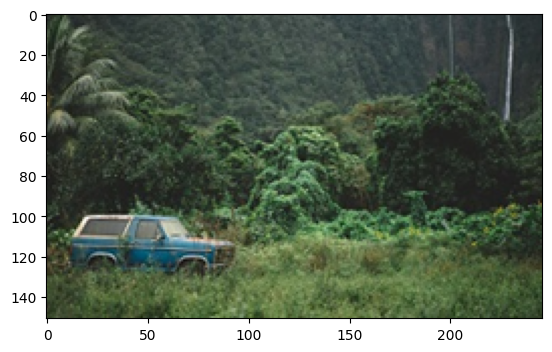

In [31]:
plt.imshow(im)

### Демонстрація вписаного водяного знаку для кожного біта (bit 1 найменш важливий)

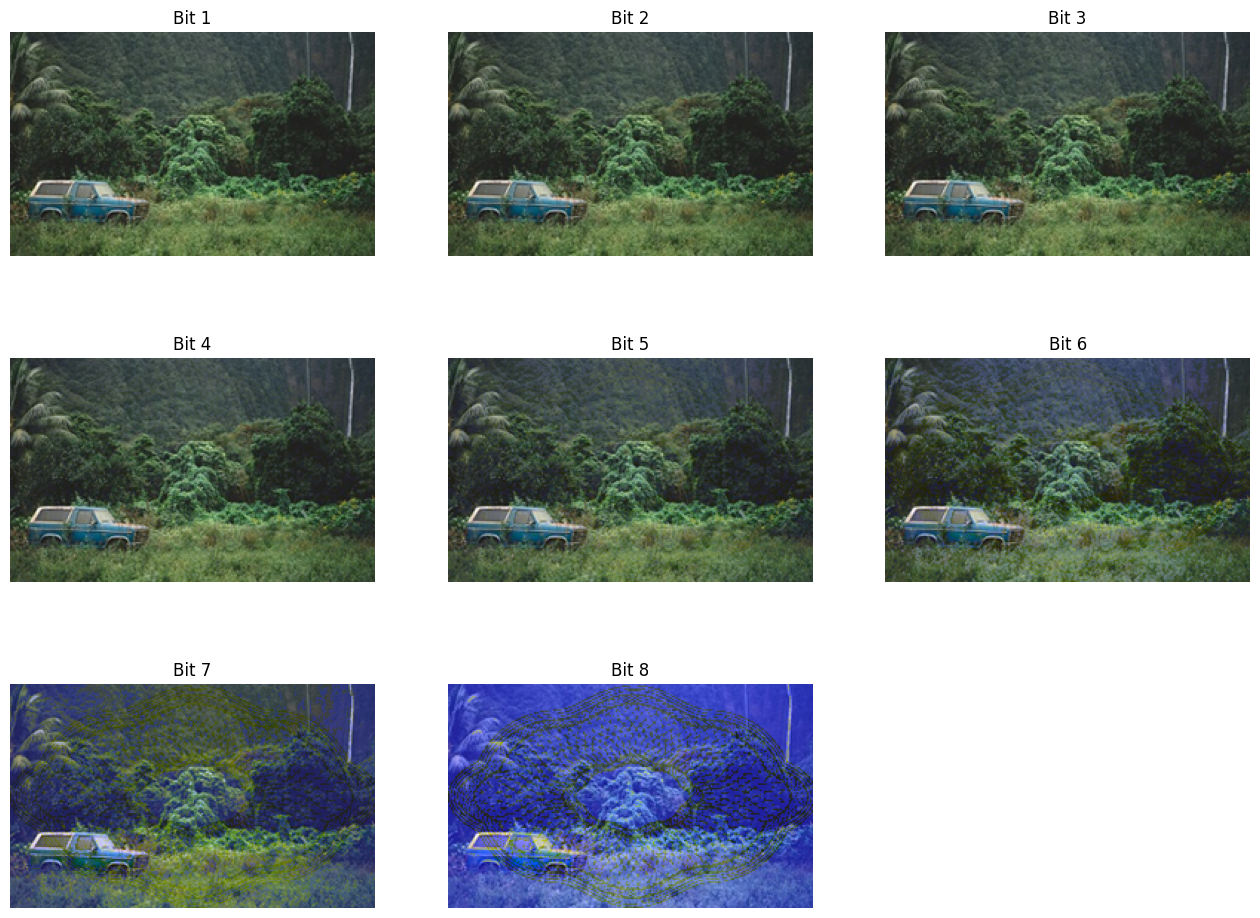

In [32]:
images = []

for bit_value in range(1, 9):
    image_with_text = insert_wm(input_image, wm_binary, bit_value)
    images.append(image_with_text)

plt.figure(figsize=(16, 12))

for i in range(8):
    plt.subplot(3, 3, i+1) 
    plt.imshow(images[i])   
    plt.title(f'Bit {i+1}')  
    plt.axis('off')         

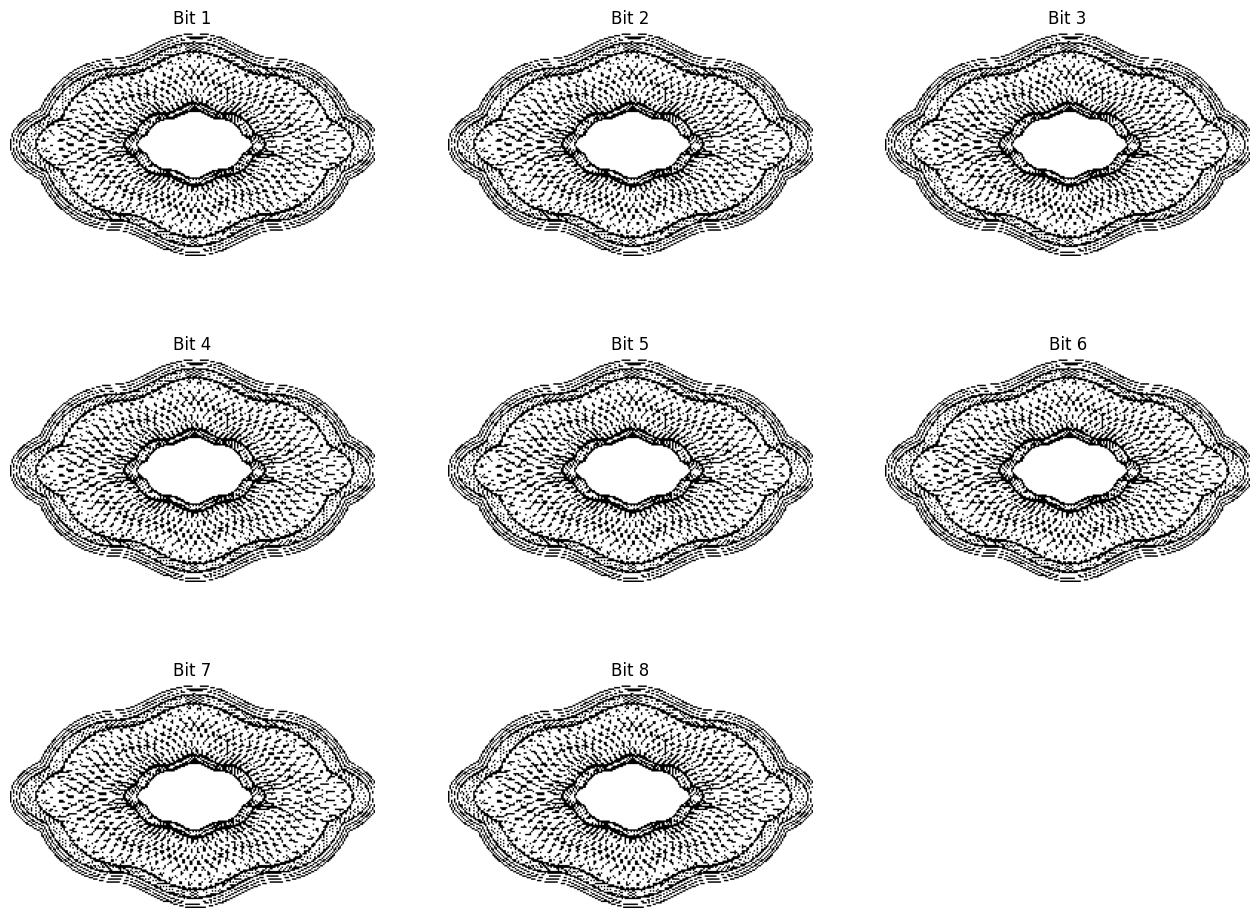

In [33]:
wms =[]
for i, image in enumerate(images):
    wm = extrect_wm(image, i+1)
    wms.append(wm)

plt.figure(figsize=(16, 12))

for i in range(8):
    plt.subplot(3, 3, i+1) 
    plt.imshow(wms[i], cmap='gray')   
    plt.title(f'Bit {i+1}')  
    plt.axis('off')   


In [34]:
test_big = insert_wm(bigger_image, wm_binary, 1)
test_big_wm = extrect_wm(test_big, 1)

In [35]:
test_small = insert_wm(smaller_image, wm_binary, 1)
test_small_wm = extrect_wm(test_small, 1)

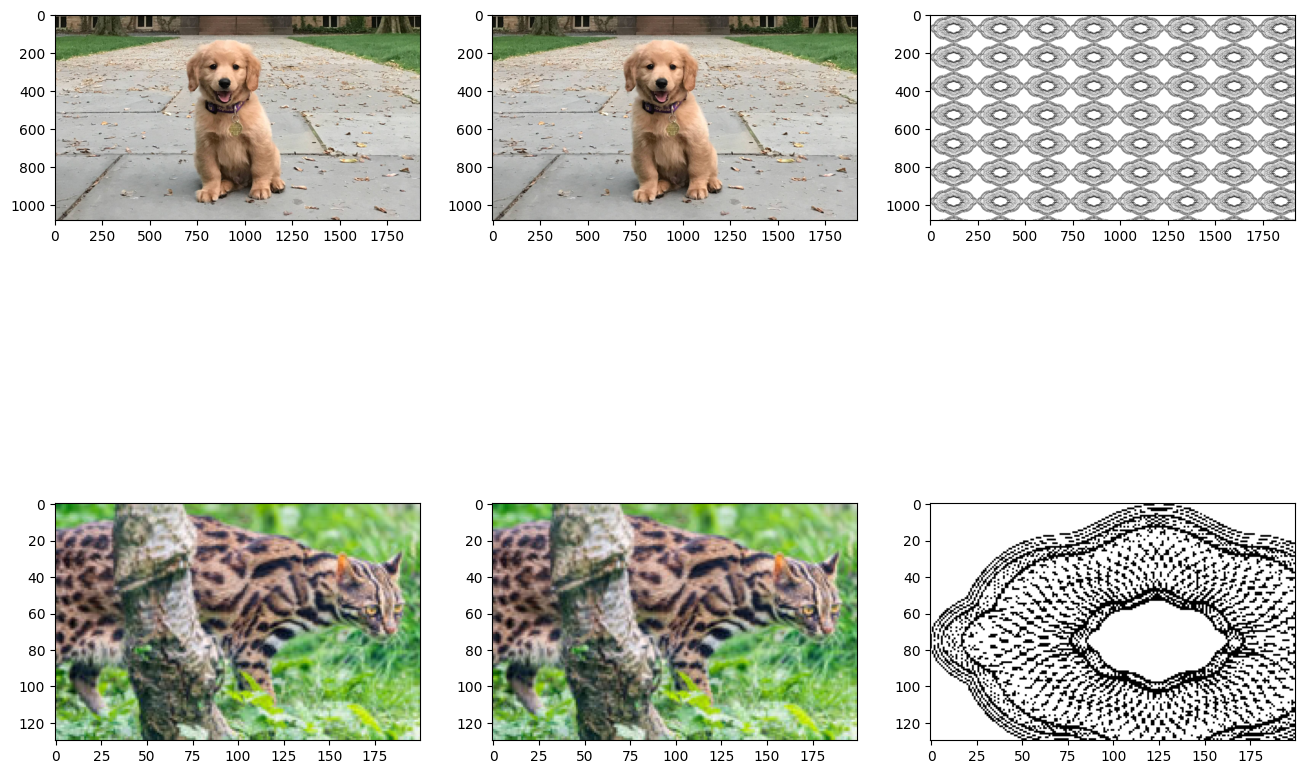

In [36]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 3, 1) 
plt.imshow(bigger_image)    

plt.subplot(2, 3, 2) 
plt.imshow(test_big)    

plt.subplot(2, 3, 3) 
plt.imshow(test_big_wm, cmap="gray")   

plt.subplot(2, 3, 4) 
plt.imshow(smaller_image)   

plt.subplot(2, 3, 5) 
plt.imshow(test_small)    

plt.subplot(2, 3, 6) 
plt.imshow(test_small_wm, cmap="gray")    
